We are interested in solving systems of the form
$Xb = y$, where $X$ is a matrix of size $n \times p$ and $y$ is our $n$ observations.
Our goal here is to recover $b$ when p > n.

We will assume that $b$ is sparse meaning that $b$ has very few non-zero entries.

In [1]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import norm

# Question 1
Generate a dataset.
- Create a matrix $X$ of size $(n, p)$ where each entry of $X$ is sampled from $\mathcal{N}(0, 1)$
- Create a vector $b$ of size $p$ where only the $k$ first entries are non-zero
- Generate the vector $y = Xb$ of size $n$

In [146]:


def generate_dataset(k, n, p):
    """Generate a dataset
    Generate a dataset where
    X has random entries sampled from N(0, 1),
    y such that Xb = y
    b has its k first entry equal to 1 and other entries are 0.

    Parameters
    ----------
    k : int
        Number of non-zero components of b
    n : int
        Number of samples
    p : int
        Number of features

    Returns
    -------
    X : array of size (n, p)
        Design matrix
    y : array of size (n,)
        Observations
    b : array of size (p,)
        Parameters
    """
    X = np.random.normal(size=(n,p))
    b = np.ones(p)
    b[:k] = 0
    y = X.dot(b)
    return X, y, b
    #raise NotImplementedError


X, y, b =  generate_dataset(k=2, n=4, p=5)
np.testing.assert_allclose(X.dot(b), y)

# Question 2
## Create a solver for linear regression
Consider the problem of finding $b$ such that $Xb = y$
- If the system has no solution return None
- If the system has one or more solution, return a solution

Help: you can remove redundant equations using the SVD of $X$.
Taking $UDV$ an SVD of $X$, solving $Xb = y$ amount to solve $(DV)b = U^T y$
in particular the zeroes in $D$ should yield zeroes in $U^T y$ (If this is not the case there is no solution and
you should return None. Otherwise return a solution).
In practice you won't encounter exact zeroes so it is enough to check that $U^Ty$ has absolute value lower than 1e-10 at coordinates where $D$ has absolute value lower than 1e-10.


In [148]:
def compute_least_squares_using_pseudo_inverse(X, y):
    pinv = np.linalg.pinv(X)
    
    b_hat = np.dot(pinv, y)
    return b_hat

In [156]:
def solve_linear_regression(X, y):
    """Find a solution of linear regression

    Find b such that Xb = y if it exists.
    Otherwise return None

    Parameters
    ----------
    X : array of size (n, p)
        Design matrix
    y : array of size (n,)
        Observations

    Return
    ------
    solution: np array of size (p,) or None
        A solution if there exists one or None if there isn't any
    """
    U, S, Vt = np.linalg.svd(X)
    D = np.zeros(X.shape)
    for i in range(len(S)):
        D[i,i] = S[i]

    Y = U.T.dot(y)
    #check there is solution
    
    for i  in range (U.shape[1]):
        if abs(D[i,:]).sum() <= 10**(-10):
            if abs(Y[i]) > 10**(-10):
                return None
        
    #Solve
    W = D.dot(Vt)
    #b_hat = np.linalg.inv(W.T.dot(W)).dot(W.T).dot(Y)
    b_hat = compute_least_squares_using_pseudo_inverse(W, Y)
    return b_hat
    #raise NotImplementedError

def test_solve_linear_regression():
    # An overdetermined but redondant system
    X = np.array([[1, 2], [3, 4], [2, 4], [6, 8]])
    b = np.array([1, 2])
    y = np.array([5, 11, 10, 22])
    sol = solve_linear_regression(X, y)
    np.testing.assert_allclose(b, sol)

    # An underdetermined system
    X = np.array([[2, 1, 2]])
    b = np.array([0, 1, 2])
    y = np.array([5])
    sol = solve_linear_regression(X, y)
    np.testing.assert_allclose(y, X.dot(sol))

    # A system without a solution
    X = np.array([[1, 2], [3, 4], [2, 4], [6, 8]])
    b = np.array([1, 2])
    y = np.array([5, 11, 11, 22])
    sol = solve_linear_regression(X, y)
    assert sol is None
    
test_solve_linear_regression()

# Question 3

Consider a matrix $S$ with boolean entries (True or False).

Build a solver for finding $b$ such that $Xb = y$ where $b$ has only non-zero coordinates at indexes $i$ such that $S[i] = True$ (if no such solution exists, return None)

In [196]:

def search_in_support(S, X, y):
    """Find a solution in the support S

    Solve Xb = y with constraints b_j = 0 for all j such 
    that S[j] = False

    Parameters
    ----------
    S : boolean array of size (p,)
        Support of b
    X : array of size (n, p)
        Design matrix
    y : array of size (n,)
        Observations

    Return
    ------
    solution: np array of size (p,) or None
        A solution if there exists one or None if there isn't any
    """
    p = len(S)
    # indices where b is non zero
    ind = [i for i in range(p) if S[i]]

    #restriction of X on the column 
    X_rest =  X[:, ind]
    b_hat = solve_linear_regression(X_rest, y)
    if b_hat is None:
        return None
    b = np.zeros(p)
    b[ind] = b_hat
    
    return b
    #raise NotImplementedError


def test_search_in_support():
    # An overdetermined but redondant system
    X = np.array([[2, 1, 2], [4, 3, 4], [3, 2, 4], [1, 6, 8]])
    b = np.array([0, 1, 2])
    y = np.array([5, 11, 10, 22])
    sol = search_in_support(np.array([False, True, True]), X, y)
    np.testing.assert_allclose(b, sol)

    # An underdetermined system
    X = np.array([[2, 1, 2]])
    b = np.array([0, 1, 2])
    y = np.array([5])
    sol = search_in_support(np.array([True, True, True]), X, y)
    np.testing.assert_allclose(y, X.dot(sol))

    # A system without a solution
    X = np.array([[2, 1, 2], [4, 3, 4], [3, 2, 4], [1, 6, 8]])
    b = np.array([0, 1, 2])
    y = np.array([5, 11, 11, 22])
    sol = search_in_support(np.array([False, True, True]), X, y)
    assert sol is None

test_search_in_support()

# Question 4

- Build a solver that takes all possible support of a given size and tries them sequentially until it finds a solution (or nothing works).

Example: the possible supports of size $2$ in dimension $3$ are
$(True, True, False), (True, False, True), (True, True, False)$

For all supports S of size `size_support`, build a solver for finding $b$ such that $Xb = y$ where $b$ has only non-zero coordinates at indexes $i$ such that $S[i] = True$, return the first solution found. If None of the support yield a solution, return None.

- Use your solver to recover b

    * Generate a dataset of with n=10, p=20,k=4
    * Do an exhaustive search among supports of size 5
    * Check that the solution found is the correct one

In [197]:
def exhaustive_search(size_support, X, y):
    """For all supports S of size `size_support` try to solve Xb = y
    If there exists a support that has at least one solution, return one solution.
    If None of the support yield a solution, return None

    Parameters
    ----------
    size_support: int
        The size of the support
    X : array of size (n, p)
        Design matrix
    y : array of size (n,)
        Observations

    Return
    ------
    solution: np array of size (p,) or None
        A solution if there exist one
    """
    #raise NotImplementedError
    
    p = X.shape[1]
    #all combinations of indicies possible
    indices = combinations(range(p), size_support)

    for ind in indices:
        
        S = np.array([False]*p)
        S[list(ind)] = True
        sol = search_in_support(S, X, y)

        if sol is not None:
            return sol
        
    return None


def test_exhaustive_search():
    # An overdetermined but redondant system
    X = np.array([[2, 1, 2], [4, 3, 4], [3, 2, 4], [1, 6, 8]])
    b = np.array([0, 1, 2])
    y = np.array([5, 11, 10, 22])

    sol = exhaustive_search(2, X, y)
    np.testing.assert_allclose(b, sol, rtol=1e-07)
    
    sol = exhaustive_search(1, X, y)
    assert sol is None


test_exhaustive_search()

In [199]:
def find_sparse_b():
    """
    - Generate a dataset of size n=10, p=20,k=4
    - Do an exhaustive search among supports of size 5
    - Check that the solution found is the correct one
    """
    #raise NotImplementedError
    #Generate a dataset
    X, y, b =  generate_dataset(k=4, n=5, p=10)

    #search
    size_support = 5
    sol = exhaustive_search(size_support, X, y)
    
    np.testing.assert_allclose(b, sol, rtol=1e-3)
    
find_sparse_b()

AssertionError: 
Not equal to tolerance rtol=0.001, atol=0

Mismatched elements: 10 / 10 (100%)
Max absolute difference: 13.44383642
Max relative difference: 1.
 x: array([0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])
 y: array([10.156803, -1.030941, 13.443836, -1.031643, 10.779809,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ])

# Question 5

- Use linprog to solve Basis pursuit:

$\min_b |b|$ with constraints $Xb = y$ where $| |$ is the l1 norm.

Help: BP can be recast as a linear program with n equality constraints
and 2p variables. Use variables for the positive and negative part of each entry of b.

linprog solves 

```
min_c c^T x
under the constrains 
A_eq x = b_eq
```

The solution is given by
`c_star = linprog(c=c, A_eq=A_eq, b_eq=b_eq)`

In [177]:
?linprog

In [200]:
def basis_pursuit(X, y):
    """ Using linprog, solve
    min_b |b| such that Xb = y where | | is the l1 norm.

    Hint: BP can be recast as a linear program with n equality constraints
    and 2p variables. Use variables for the positive and negative part
    of each entry of b

    Parameters
    -----------

    X : array of size (n, p)
        Design matrix
    y : array of size (n,)
        Observations

    Return
    -------
    sol: array of size p
        The solution of basis pursuit
    """
    #raise NotImplementedError
    n, p = X.shape
    c = np.ones(2*p)
    A_eq = np.zeros((n, 2*p))
    A_eq[:, :p] = X
    A_eq[:, p:] = -X
    b_ub = np.zeros(2*p)
    A_ub = -np.eye(2*p)
    
    B_star = linprog(c=c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=y)
    #print(B_star)
    b_star = np.array([ B_star.x[i] - B_star.x[p+i] for i in range(p)])
    return b_star


def test_basis_pursuit():
    X = np.random.randn(10, 20)
    b = np.zeros(20)
    b[0] = 1
    b[1] = 2
    y = X.dot(b)
    np.testing.assert_array_almost_equal(b, basis_pursuit(X, y))

test_basis_pursuit()

# Question 6

Take p = 40
Take k from 1 to p
Take n from 1 to p
Generate 2 datasets with the above parameters
Solve with basis pursuit

- Build the matrix `data` of size $p, p$
where `data[i, j]` contains the number of times (0, 1 or 2) 
that basis pursuit succeeds when $k=i$ and $n=j$.

Execute `test_basis_pursuit_success` to see the phase transition


<ipython-input-200-71814e06390e>:31: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  B_star = linprog(c=c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=y)
<ipython-input-200-71814e06390e>:31: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  B_star = linprog(c=c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=y)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=3.37042e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=2.38154e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=4.18189e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=9.30473e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=6.81786e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=2.03855e-19): result may 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=4.43738e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=5.62488e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=2.37692e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=1.05234e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=1.28769e-18): result may 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=1.88928e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=3.00399e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=6.13225e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=7.65693e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=9.92276e-19): result may 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=5.17238e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=7.66487e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=3.39529e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=4.73748e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=1.5491e-18): result may n

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=2.05915e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=2.30932e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=1.44063e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=3.05461e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=1.03362e-18): result may 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=6.62339e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=1.66026e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=3.20209e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=9.04212e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=4.05091e-19): result may 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=6.29929e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=6.03626e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=1.71942e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=5.06989e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=2.4211e-19): result may n

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=1.05221e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=1.15181e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=9.40267e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=1.13042e-17): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=4.883e-20): result may no

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=7.18793e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=5.2811e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=6.12635e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=1.98809e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=2.19594e-20): result may n

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=7.5945e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
<ipython-input-201-7522e8065665>:54: RuntimeWarning: invalid value encountered in true_divide
  s_max = lambda t: (delta(t) - F(t)) / ((1 + t**2) - F(t))


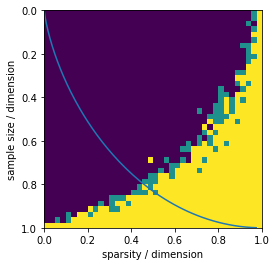

In [201]:
def compute_basis_pursuit_success():
    """
    Take p = 40
    Take k from 1 to p
    Take n from 1 to p
    Generate 2 datasets with the above parameters
    Solve with basis pursuit
    Store the result in a matrix of size (p, p) that counts
    the number of times it succeeds for each value of n and k.

    Return
    -------
    data : np array of size (p, p)
        data[i, j] contains the number of success for n = i and k=j
    """

    #raise NotImplementedError
    p=40
    data = np.zeros((p,p))
    for k in range (1,p+1):
        for n in range(1, p+1):
            success = 2
            #generate datasets
            X1, y1, b1 =  generate_dataset(k=k, n=n, p=p)
            X2, y2, b2 =  generate_dataset(k=k, n=n, p=p)
            #solving...
            
            try:
                np.testing.assert_array_almost_equal(b1, basis_pursuit(X1, y1))
            except :
                success -= 1
            try:
                np.testing.assert_array_almost_equal(b2, basis_pursuit(X2, y2))
            except:
                success -= 1
            data[k-1,n-1] = success
            
    return data


data = compute_basis_pursuit_success()

def test_basis_pursuit_success():
    """
    Plot a heatmap of the result of basis pursuit
    and check visually that it matches the theoretical results
    """

    phi = norm.pdf
    Phi = norm.cdf

    F = lambda t: 2 * ((1 + t**2) * Phi(-t) - t * phi(t))
    delta = lambda t: 4 * phi(t) / (2 * (t * (1 - 2 * Phi(-t)) + 2 * phi(t)))
    s_max = lambda t: (delta(t) - F(t)) / ((1 + t**2) - F(t))

    grid = np.linspace(0, 10, num=500)

    plt. figure()
    plt.imshow(data, extent=[0, 1, 1, 0])
    plt.plot(s_max(grid), delta(grid))
    plt.ylabel("sample size / dimension")
    plt.xlabel("sparsity / dimension")
    plt.show()


test_basis_pursuit_success()